In [200]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time

In [201]:
rootfolder = '../'

In [202]:
def psnr(img1, img2, max_pixel=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_pixel ** 2 / mse)

Useful function for plot a 2D dictionary

In [203]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [204]:
def OMP(s, D, L, tau):
    M, N = D.shape
    x = np.zeros(N)
    r = s.copy().flatten()
    omega = []

    if np.linalg.norm(r) < 1e-10:
        return x
    
    while np.linalg.norm(r) > tau and np.count_nonzero(x) < L:
        eps = np.zeros(N)
        for j in range(N):
            if j in omega:
                continue
            d_j = D[:, j]
            d = np.dot(r.T, d_j)**2/np.linalg.norm(d_j)
            eps[j] = d
        jStar = np.argmax(eps)
        omega.append(jStar)
        D_omega = D[:, omega]
        coeffs_omega = np.linalg.lstsq(D_omega, s.flatten(), rcond=None)[0]
        x[omega] = coeffs_omega
        r = s.flatten() - D_omega @ coeffs_omega
    return x

## Dictionary Learning

Load the image and rescale it in $[0,1]$

In [205]:
path_image = f'{rootfolder}/data/barbara.png'  #  barbara.png, cameraman.png, Lena512.png

img = imread(path_image) / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image and build the training set $S$

In [206]:
npatch = 10000

S = np.zeros((M, npatch))

for i in range(npatch):
    row = np.random.randint(0, img.shape[0]-p)
    col = np.random.randint(0, img.shape[1]-p)
    patch = img[row:row+p, col:col+p]
    S[:, 1] = patch.flatten()


Remove the mean from the patches (each column of $S$ must have zero-mean)

In [207]:
S = S - np.mean(S, axis=0, keepdims=True)

Define a function that implements the KSVD

In [208]:
def ksvd(S, M, N, max_iter, npatch, L, print_time=False):

    # intialize the dictionary
    D = np.random.randn(M, N)

    # normalize each column of D (zero mean and unit norm)
    norms = np.linalg.norm(D, axis=0, keepdims=True)
    D = D / np.where(norms > 1e-10, norms, 1)

    # initialize the coefficient matrix
    X = np.zeros((N, npatch))

    # Main KSVD loop
    for iter in range(max_iter):
        time_start = time.time()

        # Sparse coding step
        # perform the sparse coding via OMP of all the columns of S
        for n in range(npatch):
            X[:, n] = OMP(S[:, n], D, L, tau=1e-06)

        # Dictionary update step
        # iterate over the columns of D
        for j in range(N):
            # find which signals uses the j-th atom in the sparse coding
            omega = np.where(X[j, :] != 0)[0]

            if len(omega) == 0:
                # if the atom is never used then ignore or substitute it with a random vector
                D[:, j] = np.random.randn(M)
                D[:, j] = D[:, j] / np.linalg.norm(D[:, j])
            else:
                # compute the residual matrix E, ignoring the j-th atom
                E = S - D @ X + np.outer(D[:, j], X[j, :])

                # restrict E to the columns indicated by omega
                Eomega = E[:, omega]

                # Compute the best rank-1 approximation
                U, Sigma, V = np.linalg.svd(Eomega, full_matrices=True)

                # update the dictionary
                D[:, j] = U[:, 0]

                # update the coefficient matrix
                X[j, omega] = Sigma[0] * V[0, :]

        time_end = time.time()
        if print_time:
            print(f"Iteration {iter} runtime: {time_end-time_start}")

    return D

In [209]:
# number of columns of the dictionary
N = 256

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4


# Call the KSVD implementation
D = ksvd(S, M, N, max_iter, npatch, L, print_time=True)

Iteration 0 runtime: 0.0339663028717041
Iteration 1 runtime: 0.03322625160217285
Iteration 2 runtime: 0.032431840896606445
Iteration 3 runtime: 0.03266096115112305
Iteration 4 runtime: 0.03232121467590332
Iteration 5 runtime: 0.032095909118652344
Iteration 6 runtime: 0.03289389610290527
Iteration 7 runtime: 0.033843278884887695
Iteration 8 runtime: 0.03377199172973633
Iteration 9 runtime: 0.0348663330078125


Show the learned dictionary

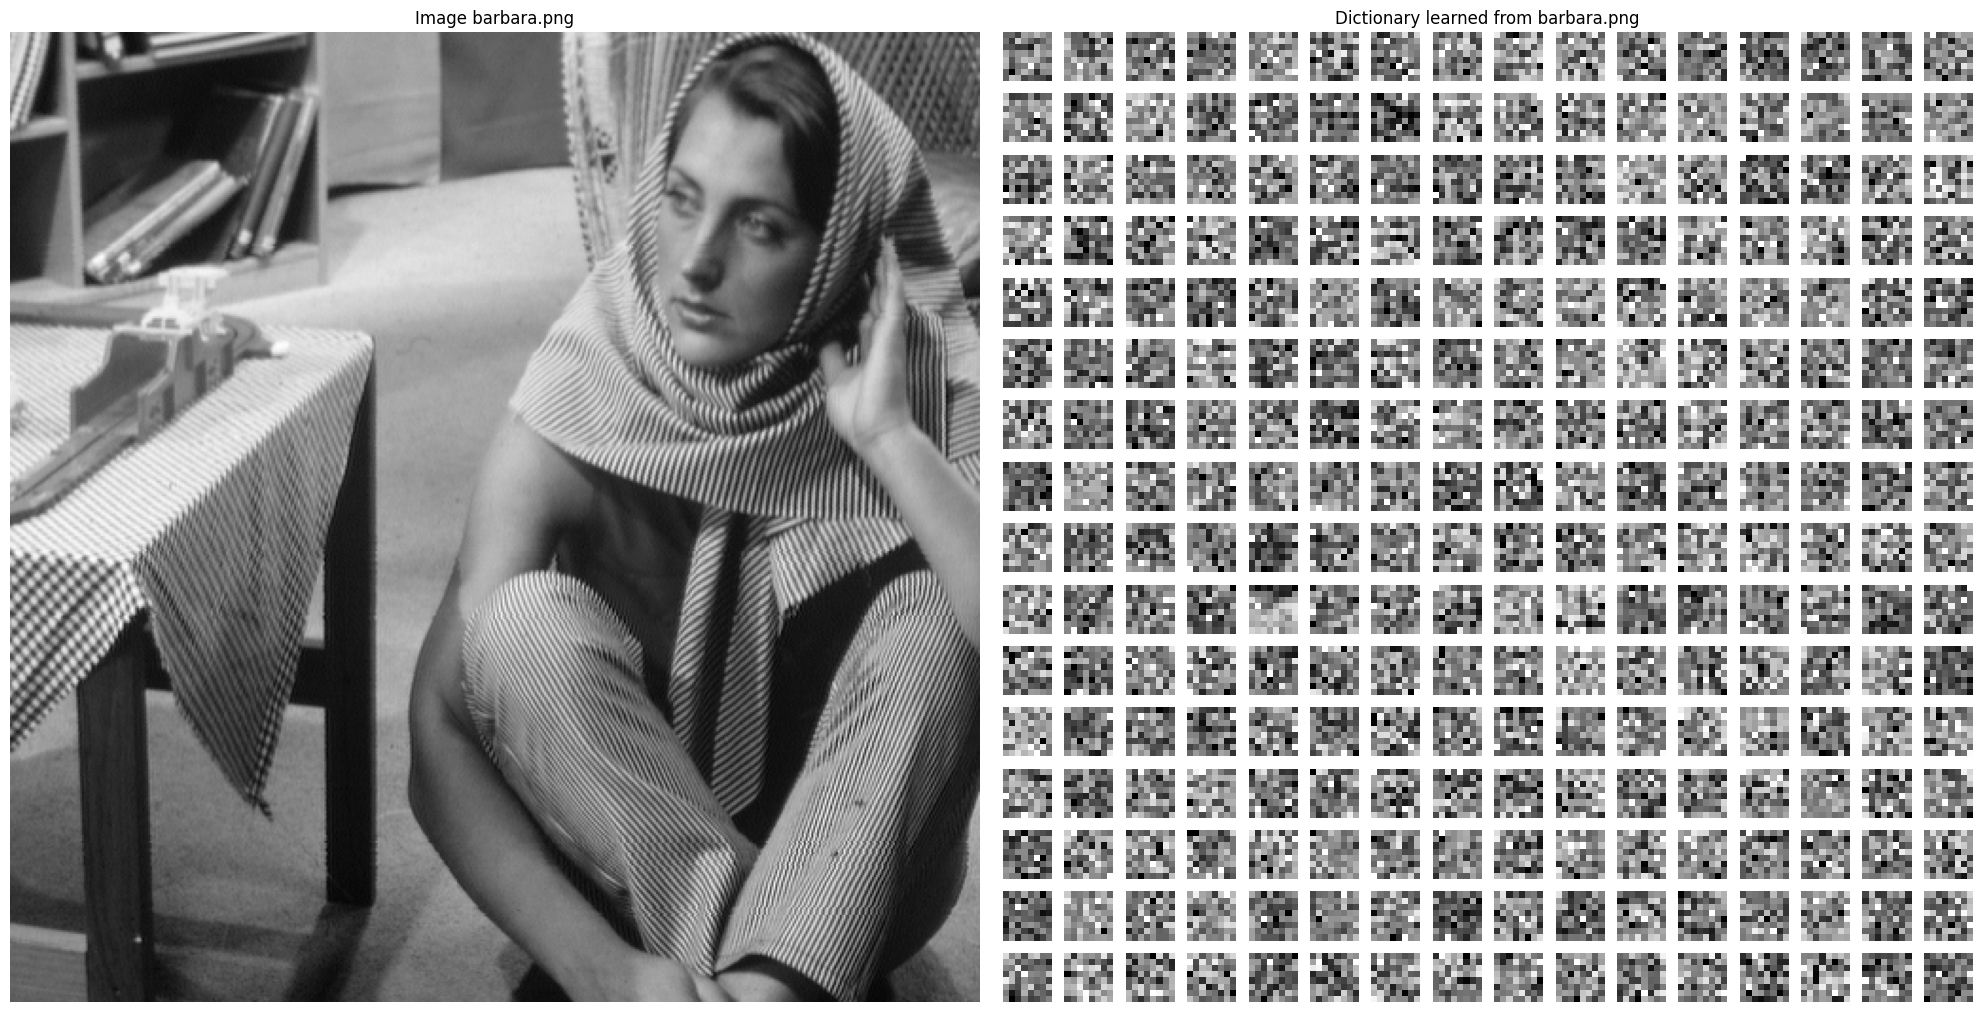

In [210]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(img, cmap='gray')
ax[0].set_title(f'Image {path_image.split("/")[-1]}')
ax[0].axis('off')

img_dict = get_dictionary_img(D)
ax[1].imshow(img_dict, cmap='gray')
ax[1].set_title(f'Dictionary learned from {path_image.split("/")[-1]}')
ax[1].axis('off')

plt.tight_layout()

## OMP denoising with learned dictionaries

In [211]:
img_clean = imread(f'{rootfolder}/data/barbara.png') / 255

# Corrupte the image

sigma_noise = 20/255
noisy_img = img_clean + sigma_noise * np.random.rand(img_clean.shape[0], img_clean.shape[1])

In [212]:
psnr_noisy = psnr(img_clean, noisy_img)

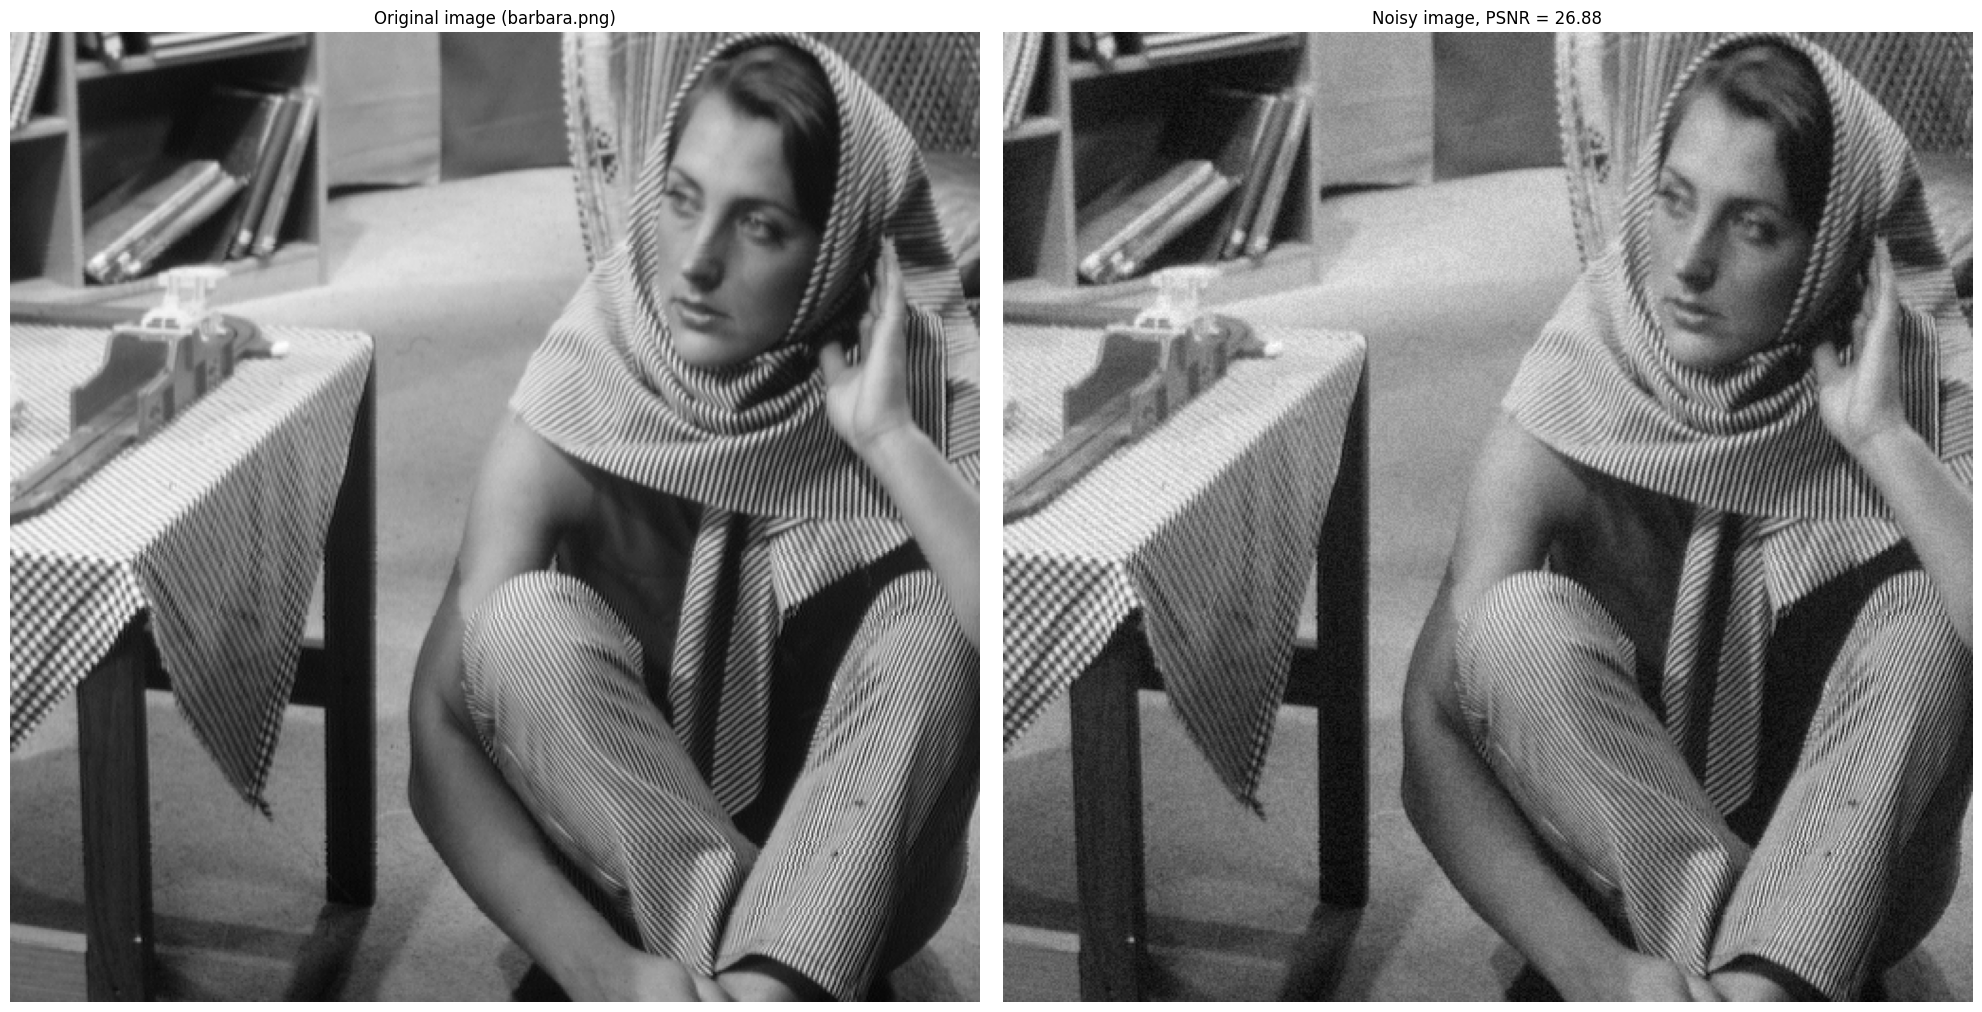

In [213]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_clean, cmap='gray')
ax[0].set_title(f'Original image (barbara.png)')
ax[0].axis('off')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')
ax[1].axis('off')

plt.tight_layout()


In [214]:
# patch size
p = 8

# number of elements in the patch
M = p ** 2

# number of columns of the dictionary
N = 256

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

Generic dictionary

In [215]:
D_generic = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

In [216]:
D_generic.shape

(64, 256)

Dictionary learned from a different image

In [217]:
img_cameraman = imread(f'{rootfolder}/data/cameraman.png') / 255

# Extract random patches
npatch = 10000

for i in range(npatch):
    row = np.random.randint(0, img_cameraman.shape[0]-p)
    col = np.random.randint(0, img_cameraman.shape[1]-p)
    patch = img_cameraman[row:row+p, col:col+p]
    S[:, i] = patch.flatten()

S = S - np.mean(S, axis=0, keepdims=True)

# Learn the dictionary
D_diff = ksvd(S, M, N, max_iter, npatch, L, print_time=True)

Iteration 0 runtime: 19.722717761993408
Iteration 1 runtime: 19.78507900238037
Iteration 2 runtime: 19.27739691734314
Iteration 3 runtime: 19.3088059425354
Iteration 4 runtime: 19.400421142578125
Iteration 5 runtime: 19.458091020584106
Iteration 6 runtime: 19.61397409439087
Iteration 7 runtime: 19.490488052368164
Iteration 8 runtime: 19.365568161010742
Iteration 9 runtime: 19.18620991706848


In [218]:
D_diff.shape

(64, 256)

Dictionary learned from the noisy image

In [219]:
# Dictionary learned from the clean image
img_clean_barbara = imread(f'{rootfolder}/data/barbara.png') / 255

img_noisy_barbara = img_clean_barbara + sigma_noise * np.random.rand(*img_clean_barbara.shape)

# Extract random patches from the CLEAN barbara image
npatch = 10000
S = np.zeros((M, npatch))

for i in range(npatch):
    row = np.random.randint(0, img_noisy_barbara.shape[0] - p)
    col = np.random.randint(0, img_noisy_barbara.shape[1] - p)
    patch = img_noisy_barbara[row:row+p, col:col+p]
    S[:, i] = patch.flatten()  # Fix: should be i, not 1

# Remove mean from patches
S = S - np.mean(S, axis=0, keepdims=True)

# Learn the dictionary from clean barbara
D_noisy = ksvd(S, M, N, max_iter, npatch, L, print_time=True)

Iteration 0 runtime: 19.373414039611816
Iteration 1 runtime: 19.273842811584473
Iteration 2 runtime: 20.11275815963745
Iteration 3 runtime: 21.17538094520569
Iteration 4 runtime: 22.61591386795044
Iteration 5 runtime: 19.017056941986084
Iteration 6 runtime: 18.821939945220947
Iteration 7 runtime: 18.77954602241516
Iteration 8 runtime: 18.616966247558594
Iteration 9 runtime: 19.376255989074707


In [220]:
D_noisy.shape

(64, 256)

Dictionary learned from the clean image

In [221]:
# Extract random patches from the CLEAN barbara image
npatch = 10000
S = np.zeros((M, npatch))

for i in range(npatch):
    row = np.random.randint(0, img_clean_barbara.shape[0] - p)
    col = np.random.randint(0, img_clean_barbara.shape[1] - p)
    patch = img_clean_barbara[row:row+p, col:col+p]
    S[:, i] = patch.flatten()  # Fix: should be i, not 1

# Remove mean from patches
S = S - np.mean(S, axis=0, keepdims=True)

# Learn the dictionary from clean barbara
D_clean = ksvd(S, M, N, max_iter, npatch, L, print_time=True)

Iteration 0 runtime: 18.82255983352661
Iteration 1 runtime: 18.89378309249878
Iteration 2 runtime: 18.911393642425537
Iteration 3 runtime: 19.13977289199829
Iteration 4 runtime: 18.863599061965942
Iteration 5 runtime: 18.924827098846436
Iteration 6 runtime: 18.7879638671875
Iteration 7 runtime: 18.88031005859375
Iteration 8 runtime: 18.990905046463013
Iteration 9 runtime: 18.900130033493042


In [222]:
D_clean.shape

(64, 256)

OMP denoising

In [223]:
def omp_denoising(noisy_img, D, step, tau):
    img_hat = np.zeros_like(noisy_img)
    weights = np.zeros_like(noisy_img)
    for i in range(0, noisy_img.shape[0] - p + 1, step):
        for j in range(0, noisy_img.shape[1] - p + 1, step):
            # Ensure we don't go beyond image boundaries
            i_end = min(i + p, noisy_img.shape[0])
            j_end = min(j + p, noisy_img.shape[1])

            # Skip if patch would be too small
            if (i_end - i) != p or (j_end - j) != p:
                continue

            # extrach the patch with the top left corner at pixel (ii, jj)
            s = img[i : i + p, j : j + p]

            # Verify patch size
            if s.shape != (p, p):
                continue

            # store and subtract the mean
            s_mean = np.mean(s)
            s_tilde = s - s_mean

            # perform the sparse coding
            x = OMP(s_tilde, D, 1, tau)

            # perform the reconstruction
            s_hat = np.dot(D, x)

            # add back the mean
            s_hat = s_hat + s_mean

            # put the denoised patch into the estimated image using uniform weights
            img_hat[i : i + p, j : j + p] += s_hat.reshape((p, p))

            # store the weight of the current patch in the weight matrix
            weights[i : i + p, j : j + p] += 1
    return img_hat

Denoising using the learned dictionaries

In [224]:
# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

In [225]:
noisy_img.shape

(512, 512)

In [226]:
print(f"Shape of Dictionaries learned:")
print(f"D_generic: {D_generic.shape}")
print(f"D_diff: {D_diff.shape}")
print(f"D_noisy: {D_noisy.shape}")
print(f"D_clean: {D_clean.shape}")

Shape of Dictionaries learned:
D_generic: (64, 256)
D_diff: (64, 256)
D_noisy: (64, 256)
D_clean: (64, 256)


Solve the four denoising problems

In [227]:
# Denoising with dictionary D_generic
img_hat_generic = omp_denoising(noisy_img, D_generic, STEP, tau)

# Denoising with dictionary D_diff
img_hat_diff = omp_denoising(noisy_img, D_diff, STEP, tau)

# Denoising with dictionary D_noisy
img_hat_noisy = omp_denoising(noisy_img, D_noisy, STEP, tau)

# Denoising with dictionary D_clean
img_hat_clean = omp_denoising(noisy_img, D_clean, STEP, tau)

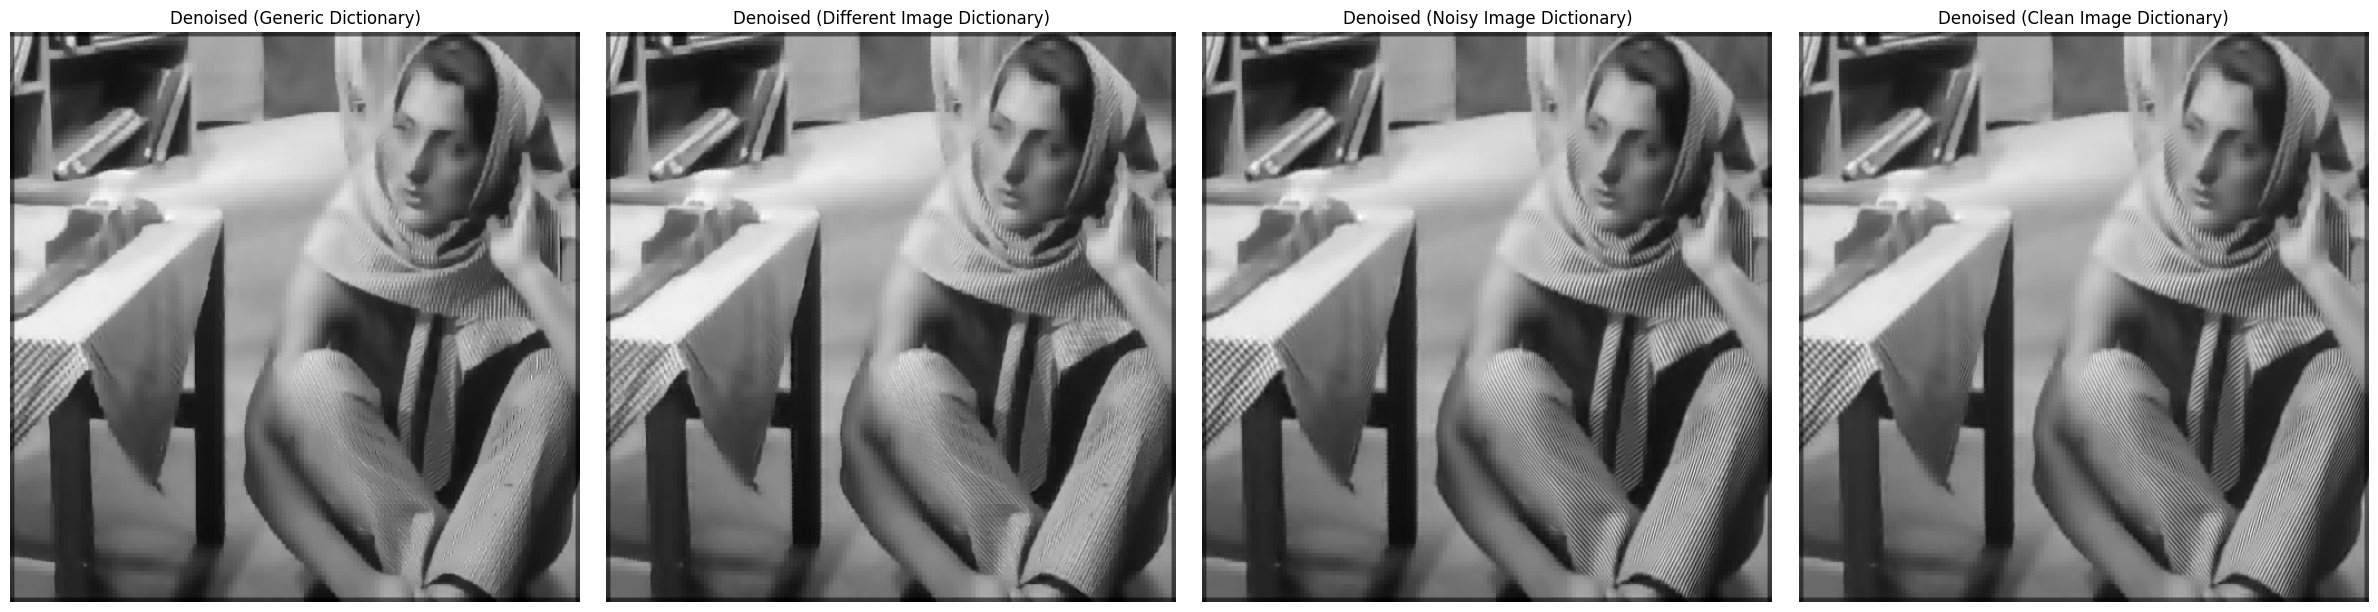

In [228]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(img_hat_generic, cmap='gray')
axes[0].set_title('Denoised (Generic Dictionary)')
axes[0].axis('off')

axes[1].imshow(img_hat_diff, cmap='gray')
axes[1].set_title('Denoised (Different Image Dictionary)')
axes[1].axis('off')

axes[2].imshow(img_hat_noisy, cmap='gray')
axes[2].set_title('Denoised (Noisy Image Dictionary)')
axes[2].axis('off')

axes[3].imshow(img_hat_clean, cmap='gray')
axes[3].set_title('Denoised (Clean Image Dictionary)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [229]:
print(f"Shape of original noisy_image: {noisy_img.shape}")
print(f"Shape of img_hat_generic: {img_hat_generic.shape}")
print(f"Shape of img_hat_diff: {img_hat_diff.shape}")
print(f"Shape of img_hat_noisy: {img_hat_noisy.shape}")
print(f"Shape of img_hat_clean: {img_hat_clean.shape}")

Shape of original noisy_image: (512, 512)
Shape of img_hat_generic: (512, 512)
Shape of img_hat_diff: (512, 512)
Shape of img_hat_noisy: (512, 512)
Shape of img_hat_clean: (512, 512)


Visualize the results

In [230]:
print("Shapes of images:")
print(f"Shape of barbara: {img_clean_barbara.shape}")
print(f"Shape of cameraman: {img_cameraman.shape}")

Shapes of images:
Shape of barbara: (512, 512)
Shape of cameraman: (256, 256)


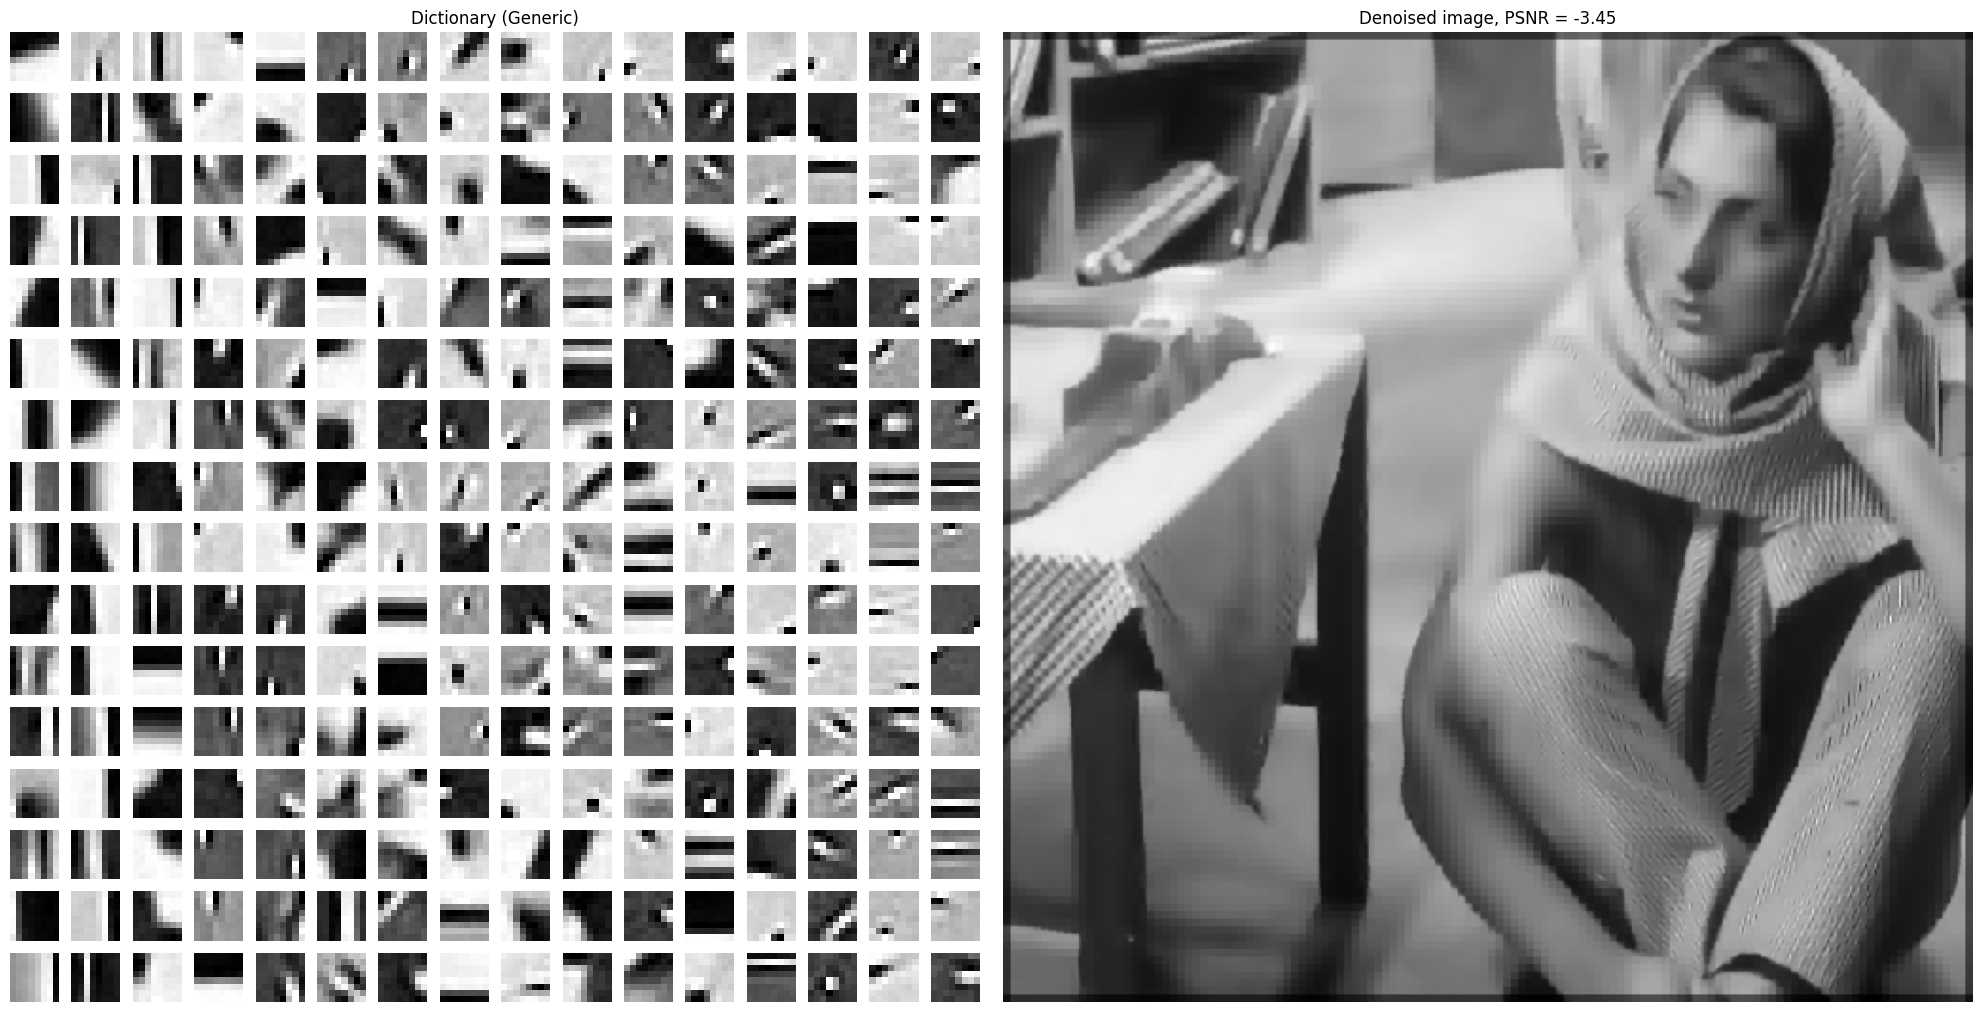

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(get_dictionary_img(D_generic), cmap='gray')
ax[0].set_title('Dictionary (Generic)')
ax[0].axis('off')

psnr_hat = psnr(img, img_hat_generic)

ax[1].imshow(img_hat_generic, cmap='gray')
ax[1].set_title(f'Denoised image, PSNR = {psnr_hat:.2f}')
ax[1].axis('off')

plt.tight_layout()

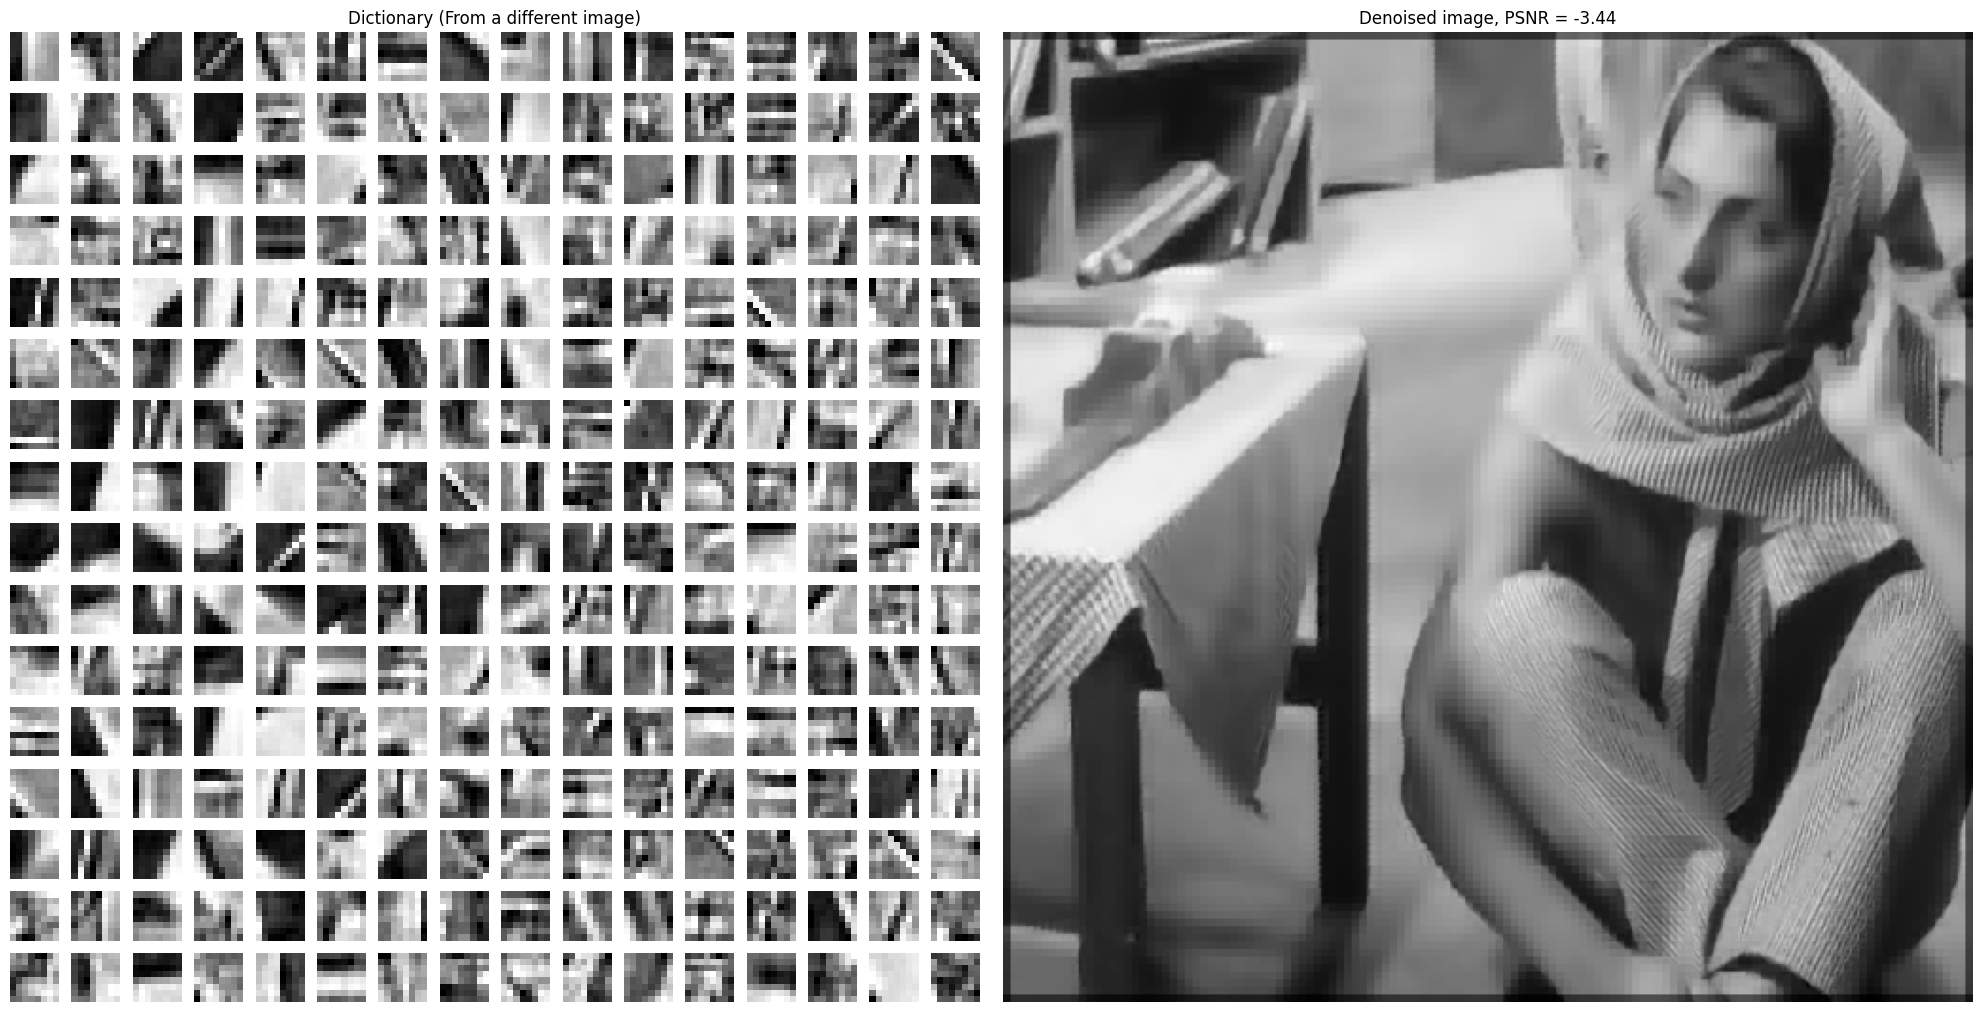

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(get_dictionary_img(D_diff), cmap='gray')
ax[0].set_title('Dictionary (From a different image)')
ax[0].axis('off')

psnr_hat = psnr(img, img_hat_diff)

ax[1].imshow(img_hat_diff, cmap='gray')
ax[1].set_title(f'Denoised image, PSNR = {psnr_hat:.2f}')
ax[1].axis('off')

plt.tight_layout()

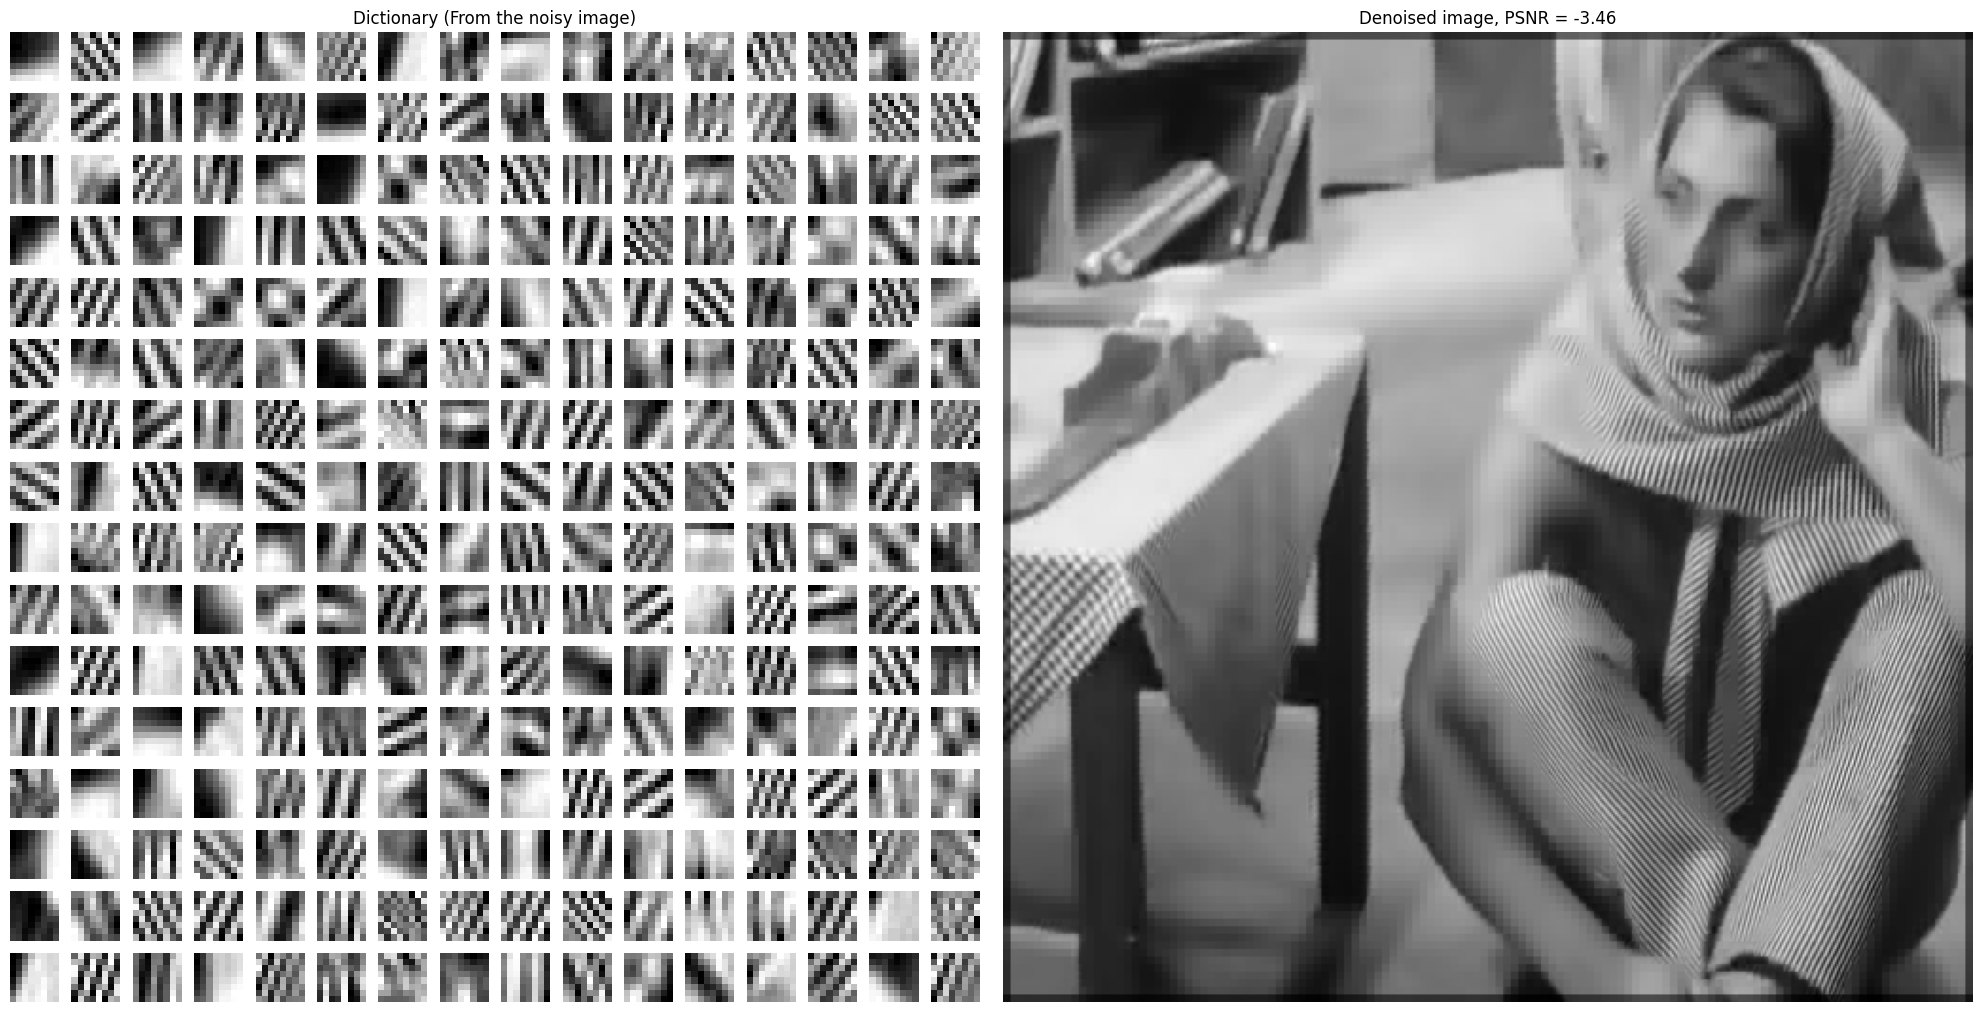

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(get_dictionary_img(D_noisy), cmap='gray')
ax[0].set_title('Dictionary (From the noisy image)')
ax[0].axis('off')

psnr_hat = psnr(img, img_hat_noisy)

ax[1].imshow(img_hat_noisy, cmap='gray')
ax[1].set_title(f'Denoised image, PSNR = {psnr_hat:.2f}')
ax[1].axis('off')

plt.tight_layout()

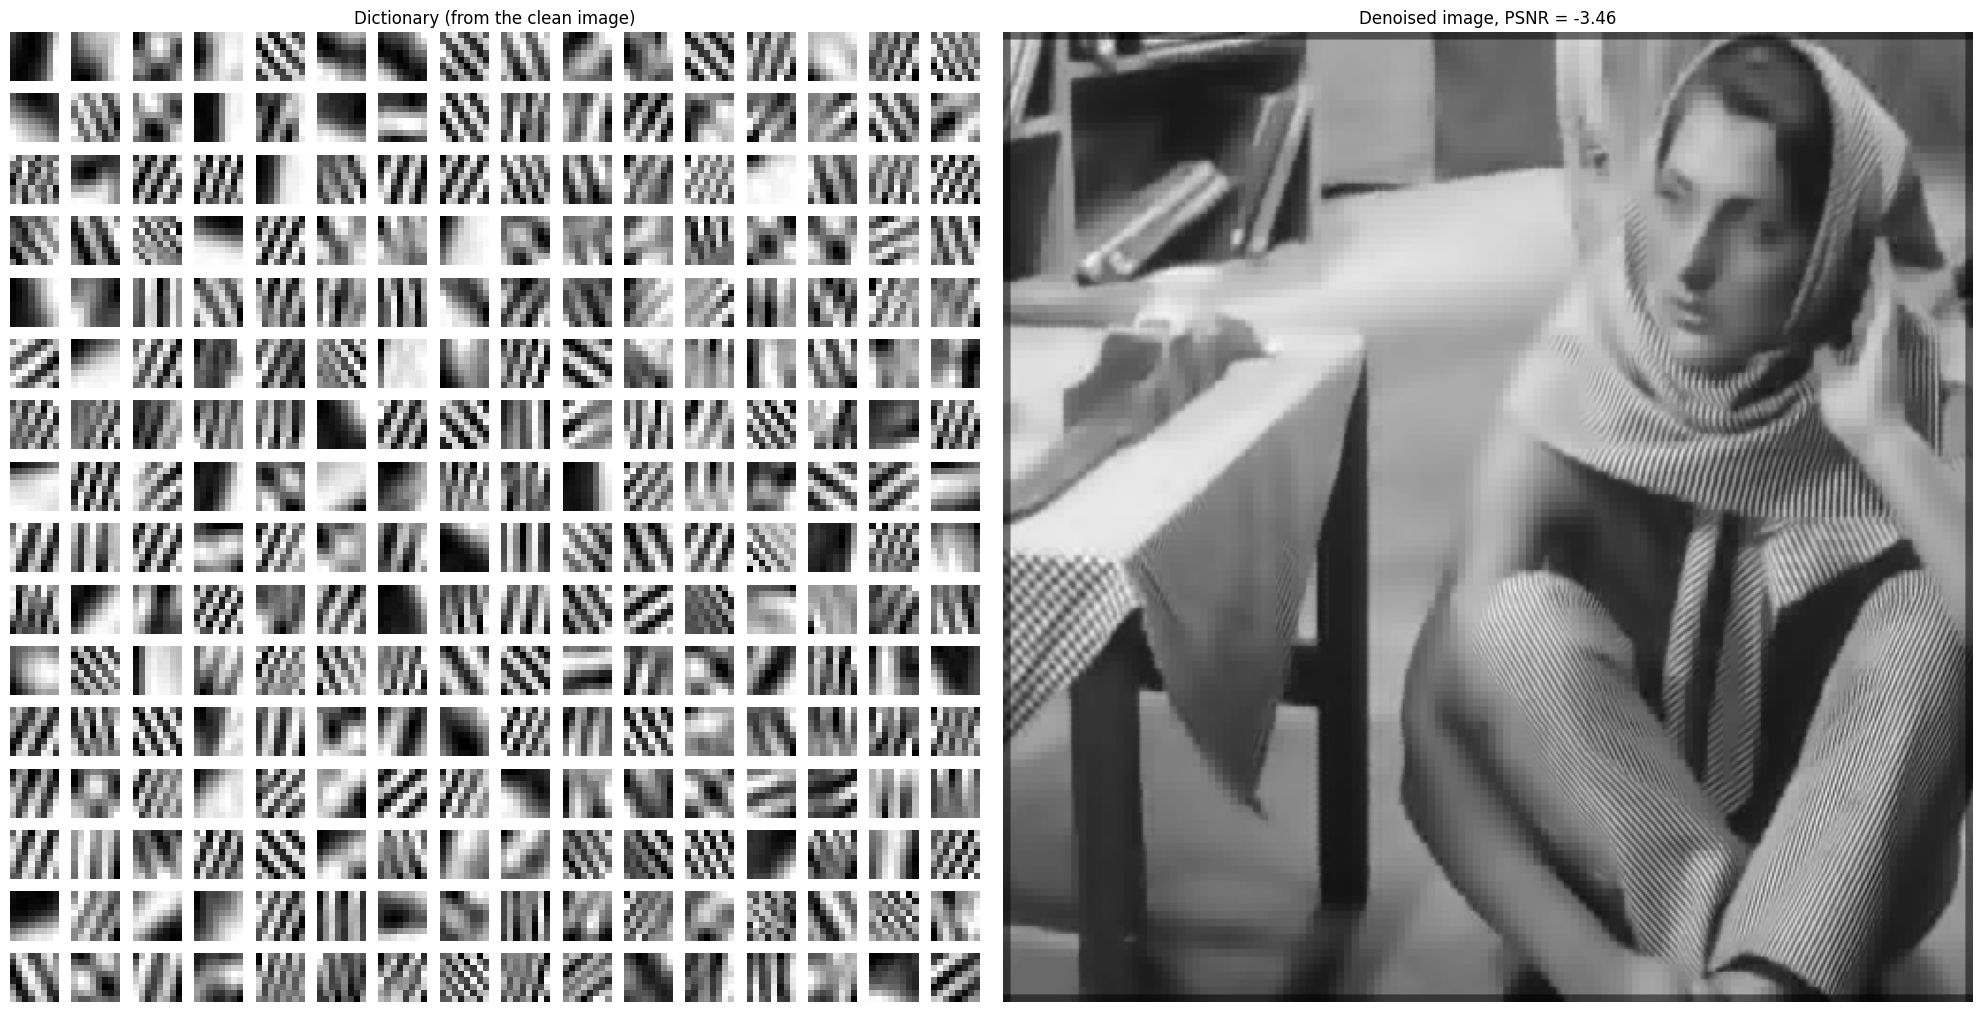

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(get_dictionary_img(D_clean), cmap='gray')
ax[0].set_title('Dictionary (from the clean image)')
ax[0].axis('off')

psnr_hat = psnr(img, img_hat_clean)

ax[1].imshow(img_hat_clean, cmap='gray')
ax[1].set_title(f'Denoised image, PSNR = {psnr_hat:.2f}')
ax[1].axis('off')

plt.tight_layout()